In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

print(float_data)

[[ 9.9652e+02 -8.0200e+00  2.6540e+02 ...  1.0300e+00  1.7500e+00
   1.5230e+02]
 [ 9.9657e+02 -8.4100e+00  2.6501e+02 ...  7.2000e-01  1.5000e+00
   1.3610e+02]
 [ 9.9653e+02 -8.5100e+00  2.6491e+02 ...  1.9000e-01  6.3000e-01
   1.7160e+02]
 ...
 [ 9.9982e+02 -3.1600e+00  2.7001e+02 ...  1.0800e+00  2.0000e+00
   2.1520e+02]
 [ 9.9981e+02 -4.2300e+00  2.6894e+02 ...  1.4900e+00  2.1600e+00
   2.2580e+02]
 [ 9.9982e+02 -4.8200e+00  2.6836e+02 ...  1.2300e+00  1.9600e+00
   1.8490e+02]]


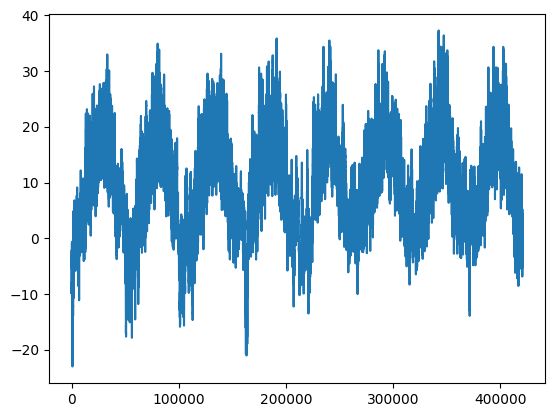

In [3]:
from tokenize import PlainToken
import matplotlib.pyplot as plt
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

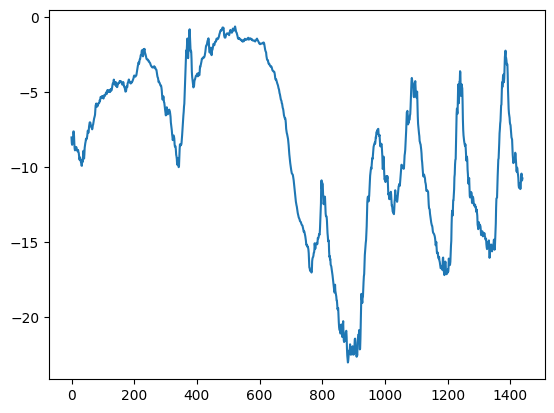

In [4]:
plt.plot(range(1440), temp[:1440])

lookback 타임스텝 만큼 이전으로 돌아가서 매 steps 타임스탭마다 샘플링  
이 데이터를 바탕으로 delay 타임스텝 이후의 온도 예측

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

간단한 상식 수준의 기준점 지정  
지금으로부터 24시간 후 온도는 지금과 동일할 것이라고 가정 및 예측하여 평가

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28966926188727593


In [9]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


Feed Forward Network Test

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


/tmp/ipykernel_8017/2718699035.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
2022-08-31 15:02:44.073443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


500/500 [==============================] - 10s 17ms/step - loss: 1.1460 - val_loss: 0.5057
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3594 - val_loss: 0.3177
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2832 - val_loss: 0.3247
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2619 - val_loss: 0.3022
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2513 - val_loss: 0.3142
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2411 - val_loss: 0.3048
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2356 - val_loss: 0.3330
Epoch 8/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2299 - val_loss: 0.3196
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2241 - val_loss: 0.3168
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2194 - val_loss: 0.3190

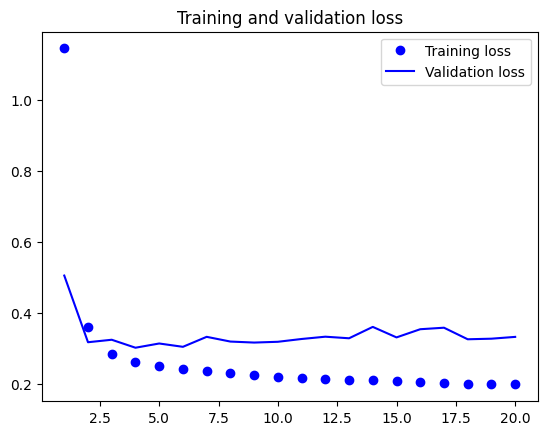

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

GRU test

In [17]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


/tmp/ipykernel_8017/1161825369.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)
2022-08-31 18:02:35.463135: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


500/500 [==============================] - 18s 30ms/step - loss: 0.3065 - val_loss: 0.2729
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2834 - val_loss: 0.2636
Epoch 3/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2754 - val_loss: 0.2665
Epoch 4/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2708 - val_loss: 0.2674
Epoch 5/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2635 - val_loss: 0.2714
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2601 - val_loss: 0.2669
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2529 - val_loss: 0.2779
Epoch 8/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2502 - val_loss: 0.2733
Epoch 9/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2437 - val_loss: 0.2779
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2400 - val_los

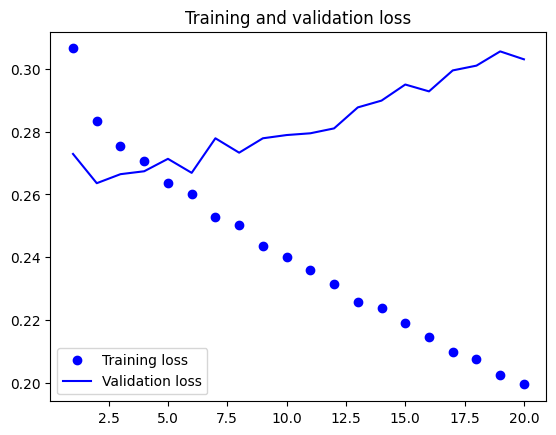

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()